In [3]:
import numpy as np
import pandas as pd
from tensorflow.keras.utils import to_categorical
import matplotlib.pyplot as plt
import seaborn as sns

def load_file(filepath):
    dataframe = pd.read_csv(filepath, header=None, delim_whitespace=True)
    return dataframe.values

# load a list of files and return as a 3d numpy array
def load_group(filenames, prefix=''):
    loaded = list()
    for name in filenames:
        data = load_file(prefix + name)
        loaded.append(data)
    # stack group so that features are the 3rd dimension
    loaded = np.dstack(loaded)
    return loaded

# load a dataset group, such as train or test
def load_dataset_group(group, prefix=''):
    filepath = prefix + group + '/Inertial Signals/'
    # load all 9 files as a single array
    filenames = list()
    # total acceleration
    filenames += ['total_acc_x_'+group+'.txt', 'total_acc_y_'+group+'.txt', 'total_acc_z_'+group+'.txt']
    # body acceleration
    filenames += ['body_acc_x_'+group+'.txt', 'body_acc_y_'+group+'.txt', 'body_acc_z_'+group+'.txt']
    # body gyroscope
    filenames += ['body_gyro_x_'+group+'.txt', 'body_gyro_y_'+group+'.txt', 'body_gyro_z_'+group+'.txt']
    # load input data
    X = load_group(filenames, filepath)
    # load class output
    y = load_file(prefix + group + '/y_'+group+'.txt')
    return X, y


# load the dataset, returns train and test X and y elements
def load_dataset(prefix=''):
    # load all train
    trainX, trainy = load_dataset_group('train', prefix + '/content/drive/MyDrive/Colab Notebooks/UCI-HAR/')
    # load all test
    testX, testy = load_dataset_group('test', prefix + '/content/drive/MyDrive/Colab Notebooks/UCI-HAR/')

    #zero-offset class values
    trainy = trainy - 1
    testy = testy - 1
    #one hot encode y
    trainy_one_hot = to_categorical(trainy)
    testy_one_hot = to_categorical(testy)
    print(trainX.shape, trainy.shape, trainy_one_hot.shape, testX.shape, testy.shape, testy_one_hot.shape)
    return trainX, trainy, trainy_one_hot, testX, testy, testy_one_hot

trainX, trainy, trainy_one_hot, testX, testy, testy_one_hot = load_dataset()

from sklearn.model_selection import train_test_split

X_train,X_val,y_train_one_hot,y_val_one_hot,y_train,y_val=train_test_split(trainX, trainy_one_hot, trainy,test_size=0.2,random_state=100)

X_train.shape,X_val.shape,y_train_one_hot.shape,y_val_one_hot.shape,y_train.shape,y_val.shape

/tmp/ipython-input-1657982041.py:8: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  dataframe = pd.read_csv(filepath, header=None, delim_whitespace=True)
/tmp/ipython-input-1657982041.py:8: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  dataframe = pd.read_csv(filepath, header=None, delim_whitespace=True)
/tmp/ipython-input-1657982041.py:8: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  dataframe = pd.read_csv(filepath, header=None, delim_whitespace=True)
/tmp/ipython-input-1657982041.py:8: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  dataframe = pd.read_csv(filepath, header=None, delim_whitespace=True)


(7352, 128, 9) (7352, 1) (7352, 6) (2947, 128, 9) (2947, 1) (2947, 6)


((5881, 128, 9), (1471, 128, 9), (5881, 6), (1471, 6), (5881, 1), (1471, 1))

In [4]:
n_timesteps, n_features, n_outputs = X_train.shape[1], X_train.shape[2], y_train_one_hot.shape[1]

In [40]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import (
    Input, Dense, Conv1D, MaxPooling1D,
    BatchNormalization, Activation, Add, GlobalAveragePooling1D,
    LayerNormalization, MultiHeadAttention, Dropout, Embedding
)
from tensorflow.keras.optimizers import Adam
import tensorflow as tf

def resnet_block(input_tensor, filters, kernel_size):
    x = Conv1D(filters, kernel_size, padding='same')(input_tensor)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = Conv1D(filters, kernel_size, padding='same')(x)
    x = BatchNormalization()(x)

    if input_tensor.shape[-1] != filters:
        shortcut = Conv1D(filters, 1, padding='same')(input_tensor)
        shortcut = BatchNormalization()(shortcut)
    else:
        shortcut = input_tensor

    x = Add()([x, shortcut])
    x = Activation('relu')(x)
    return x

def transformer_encoder(inputs, embed_dim, num_heads, ff_dim, dropout_rate=0.1):
    attention = MultiHeadAttention(num_heads=num_heads, key_dim=embed_dim)
    x = LayerNormalization()(inputs)
    attention_output = attention(x, x)
    attention_output = Dropout(dropout_rate)(attention_output)
    x1 = Add()([x, attention_output])

    ffn = tf.keras.Sequential(
        [Dense(ff_dim, activation="relu"), Dense(embed_dim),]
    )
    x2 = LayerNormalization()(x1)
    ffn_output = ffn(x2)
    ffn_output = Dropout(dropout_rate)(ffn_output)
    return Add()([x2, ffn_output])

transformer_embed_dim = 64
num_heads = 4
ff_dim = 128
num_blocks = 2
dropout_rate = 0.1

inputs = Input(shape=(n_timesteps, n_features))

x = Conv1D(transformer_embed_dim, 7, padding='same')(inputs)
x = BatchNormalization()(x)
x = Activation('relu')(x)

x = resnet_block(x, transformer_embed_dim, kernel_size=3)
x = resnet_block(x, transformer_embed_dim, kernel_size=3)

current_timesteps = x.shape[1] # 128
positions = tf.range(start=0, limit=current_timesteps, delta=1)
position_embedding = Embedding(input_dim=current_timesteps, output_dim=transformer_embed_dim)(positions)
x = x + position_embedding

for _ in range(num_blocks):
    x = transformer_encoder(
        x, transformer_embed_dim, num_heads, ff_dim, dropout_rate
    )

x = GlobalAveragePooling1D()(x)
x = Dropout(0.2)(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.2)(x)
outputs = Dense(n_outputs, activation='softmax')(x)

hybrid_model = Model(inputs=inputs, outputs=outputs)

hybrid_model.compile(
    loss='categorical_crossentropy',
    optimizer=Adam(learning_rate=0.001),
    metrics=['accuracy']
)
hybrid_model.summary()

Model: "functional_14"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_20      │ (None, 128, 9)    │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_57 (Conv1D)  │ (None, 128, 64)   │      4,096 │ input_layer_20[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 128, 64)   │        256 │ conv1d_57[0][0]   │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_42       │ (None, 128, 64)   │          0 │ batch_normalizat… │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_58 (Conv1D)  │ (None, 128, 64)   │     12,352 │ activation_42[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 128, 64)   │        256 │ conv1d_58[0][0]   │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_43       │ (None, 128, 64)   │          0 │ batch_normalizat… │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_59 (Conv1D)  │ (None, 128, 64)   │     12,352 │ activation_43[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 128, 64)   │        256 │ conv1d_59[0][0]   │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_34 (Add)        │ (None, 128, 64)   │          0 │ batch_normalizat… │
│                     │                   │            │ activation_42[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_44       │ (None, 128, 64)   │          0 │ add_34[0][0]      │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_60 (Conv1D)  │ (None, 128, 64)   │     12,352 │ activation_44[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 128, 64)   │        256 │ conv1d_60[0][0]   │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_45       │ (None, 128, 64)   │          0 │ batch_normalizat… │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_61 (Conv1D)  │ (None, 128, 64)   │     12,352 │ activation_45[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 128, 64)   │        256 │ conv1d_61[0][0]   │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_35 (Add)        │ (None, 128, 64)   │          0 │ batch_normalizat… │
│                     │                   │            │ activation_44[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_46       │ (None, 128, 64)   │          0 │ add_35[0][0]      │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼─────────────────

 Total params: 230,278 (899.52 KB)

 Trainable params: 229,638 (897.02 KB)

 Non-trainable params: 640 (2.50 KB)

In [41]:
model_history_hybrid = hybrid_model.fit(
    X_train,
    y_train_one_hot,
    epochs=30,
    batch_size=32,
    validation_data=(X_val, y_val_one_hot)
)

Epoch 1/30
184/184 ━━━━━━━━━━━━━━━━━━━━ 33s 76ms/step - accuracy: 0.7675 - loss: 0.6003 - val_accuracy: 0.6091 - val_loss: 1.4987
Epoch 2/30
184/184 ━━━━━━━━━━━━━━━━━━━━ 19s 11ms/step - accuracy: 0.9288 - loss: 0.1866 - val_accuracy: 0.9368 - val_loss: 0.1508
Epoch 3/30
184/184 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - accuracy: 0.9412 - loss: 0.1428 - val_accuracy: 0.9531 - val_loss: 0.1190
Epoch 4/30
184/184 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - accuracy: 0.9472 - loss: 0.1288 - val_accuracy: 0.9429 - val_loss: 0.1395
Epoch 5/30
184/184 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.9383 - loss: 0.1505 - val_accuracy: 0.9497 - val_loss: 0.1524
Epoch 6/30
184/184 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.9464 - loss: 0.1333 - val_accuracy: 0.9531 - val_loss: 0.1144
Epoch 7/30
184/184 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.9522 - loss: 0.1228 - val_accuracy: 0.9388 - val_loss: 0.1550
Epoch 8/30
184/184 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.9530 - loss: 0.1310 - val_ac

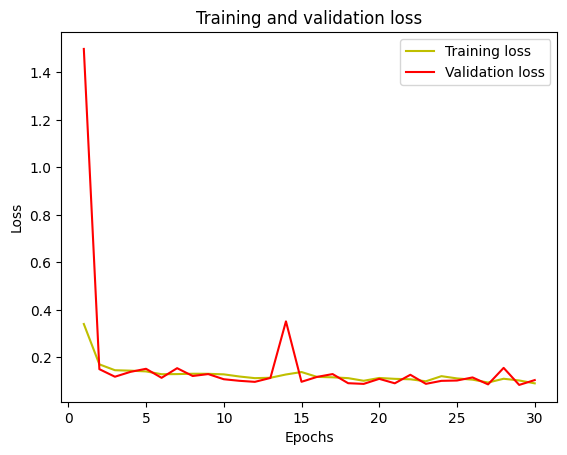

In [42]:
import matplotlib.pyplot as plt
import seaborn as sns

loss =model_history_hybrid.history['loss']
val_loss =model_history_hybrid.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

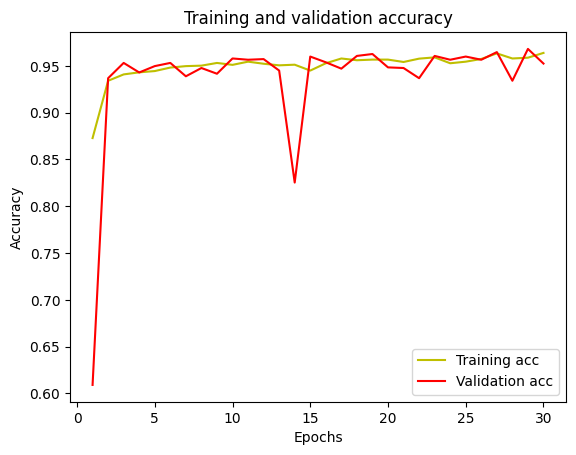

In [43]:
acc =model_history_hybrid.history['accuracy']
val_acc =model_history_hybrid.history['val_accuracy']
plt.plot(epochs, acc, 'y', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

93/93 ━━━━━━━━━━━━━━━━━━━━ 3s 18ms/step
[[489   5   2   0   0   0]
 [ 13 439  19   0   0   0]
 [  0   2 418   0   0   0]
 [  1   0   0 330 160   0]
 [  0   0   0  18 514   0]
 [  0   0   0   0   0 537]]
0.9253478113335596
              precision    recall  f1-score   support

           0       0.97      0.99      0.98       496
           1       0.98      0.93      0.96       471
           2       0.95      1.00      0.97       420
           3       0.95      0.67      0.79       491
           4       0.76      0.97      0.85       532
           5       1.00      1.00      1.00       537

    accuracy                           0.93      2947
   macro avg       0.94      0.93      0.92      2947
weighted avg       0.93      0.93      0.92      2947



<Axes: >

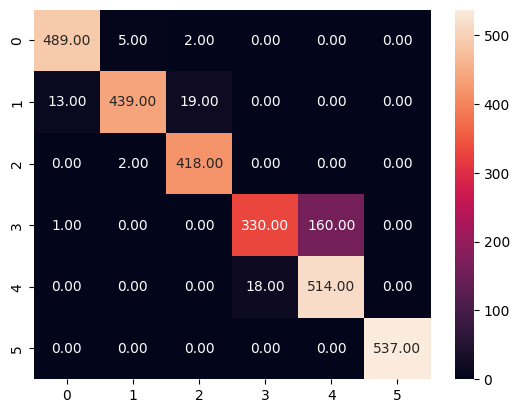

In [44]:
from sklearn.metrics import confusion_matrix,classification_report,accuracy_score
pred=hybrid_model.predict(testX)
pred=np.argmax(pred, axis=-1)
cm=confusion_matrix(testy,pred)
print(cm)
print(accuracy_score(testy,pred))
print(classification_report(testy,pred))
sns.heatmap(cm, annot=True, fmt = '.2f')